# 0. Imports

## 0.1 Libraries

In [237]:
import numpy as np
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import ks_2samp

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score,mean_squared_error, mean_absolute_percentage_error,mean_absolute_error
from sklearn.preprocessing import OrdinalEncoder

import shap
import category_encoders as ce
from scipy.stats import skew
from statsmodels.api import OLS, add_constant
from sklearn.preprocessing import PowerTransformer

## 0.2. Model and data from part 1

In [238]:
from pickle import load
with open("../Part_1/part_1_model.pkl", "rb") as f:
    linear_reg = load(f)

df_train = pd.read_csv('../Part_1/data/processed_train_data.csv',index_col='id')
df_test = pd.read_csv('../Part_1/data/processed_test_data.csv',index_col='id')

In [239]:
df_train.head()

,model_year,milage,accident,clean_title,horse_power,tank_size,num_cylinders,automatic,manual,dual,...,int_col_Brown,int_col_Ebony,int_col_Global Black,int_col_Gray,int_col_Jet Black,int_col_Orange,int_col_Red,int_col_White,int_col_other,price
id,,,,,,,,,,,,,,,,,,,,,
0,2007,213000,False,True,172.0,1.6,4.0,True,False,False,...,False,False,False,True,False,False,False,False,False,4200
1,2002,143250,True,True,252.0,3.9,8.0,True,False,False,...,False,False,False,False,False,False,False,False,False,4999
2,2002,136731,False,True,320.0,5.3,8.0,True,False,False,...,False,False,False,True,False,False,False,False,False,13900
3,2017,19500,False,True,420.0,5.0,8.0,False,False,True,...,False,False,False,False,False,False,False,False,False,45000
4,2021,7388,False,True,208.0,2.0,4.0,True,False,False,...,False,False,False,False,False,False,False,False,False,97500


In [240]:
df_test.head()

,model_year,milage,accident,clean_title,horse_power,tank_size,num_cylinders,automatic,manual,dual,...,int_col_Brown,int_col_Ebony,int_col_Global Black,int_col_Gray,int_col_Jet Black,int_col_Orange,int_col_Red,int_col_White,int_col_other,price
id,,,,,,,,,,,,,,,,,,,,,
150826,2021,52253,True,False,343.0,2.5,6.0,True,False,False,...,False,False,False,False,False,False,False,False,True,25215
150827,2006,127500,False,True,208.0,2.0,4.0,True,False,False,...,False,False,False,False,False,False,False,False,False,9750
150828,2005,16300,False,True,239.0,4.6,8.0,True,False,False,...,False,False,False,True,False,False,False,False,False,19950
150829,2012,13133,False,True,333.0,3.0,6.0,True,False,False,...,False,False,False,False,False,False,False,False,False,13999
150830,2011,106000,True,True,300.0,3.0,6.0,False,False,True,...,False,False,False,False,False,False,False,False,False,6900


In [241]:
def train_score_model (df_train, df_test):
	X_train = df_train.drop(columns='price')
	y_train = df_train['price']
	X_test = df_test.drop(columns='price')
	y_test = df_test['price']
	
	linear_reg = LinearRegression()
	linear_reg.fit(X_train, y_train)
	y_pred = linear_reg.predict(X_test)
	
	r2 = r2_score(y_test, y_pred)
	
	return r2

# Part 1: Error Analysis Conclusions & Work Plan

## Sanity Check
To verify that the model errors are caused by the simplicity of the model we're using, we performed a sanity check by predicting the train data prices using a simple Linear Regression model on the train data. Below is the result:

In [242]:
print(f'The R2 score of the model train and tested on the train data is: {train_score_model(df_train, df_train)}')

The R2 score of the model train and tested on the train data is: 0.10881674237978001


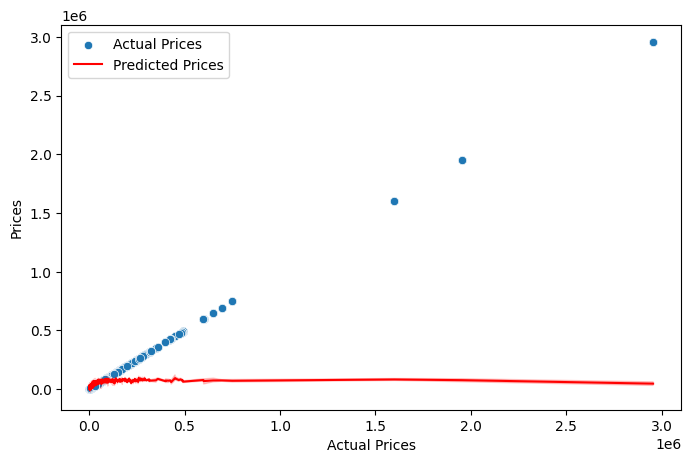

In [243]:
y_train = df_train['price']
X_train = df_train.drop(columns='price')
y_test = df_test['price']
X_test = df_test.drop(columns='price')

linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)
y_pred = linear_reg.predict(X_test)

# Create the scatter plot and line plot
fig, ax = plt.subplots(figsize=(8, 5))
sns.scatterplot(x=y_test, y=y_test, ax=ax, label='Actual Prices')
sns.lineplot(x=y_test, y=y_pred, ax=ax, color='red', label='Predicted Prices')

ax.set_xlabel('Actual Prices')
ax.set_ylabel('Prices')
ax.legend()
plt.show()

We wanted to confirm that the model errors are not due to inconsistencies in the train and test data distributions, so we plotted them.

**Observations**:
- The scatter plot shows a poor performance of the model, with predicted prices (red line) deviating significantly from the actual prices.
- To further validate this, we compared the distributions of the train and test datasets:
    - The train set (blue) and test set (orange) distributions are largely similar.
    - This was confirmed visually and using a Two-Sample KS test, which quantifies the similarity between distributions.  

**Conclusion**:  

While the distributions are balanced, normalization may still be necessary to address imbalanced data ranges and potential outliers.

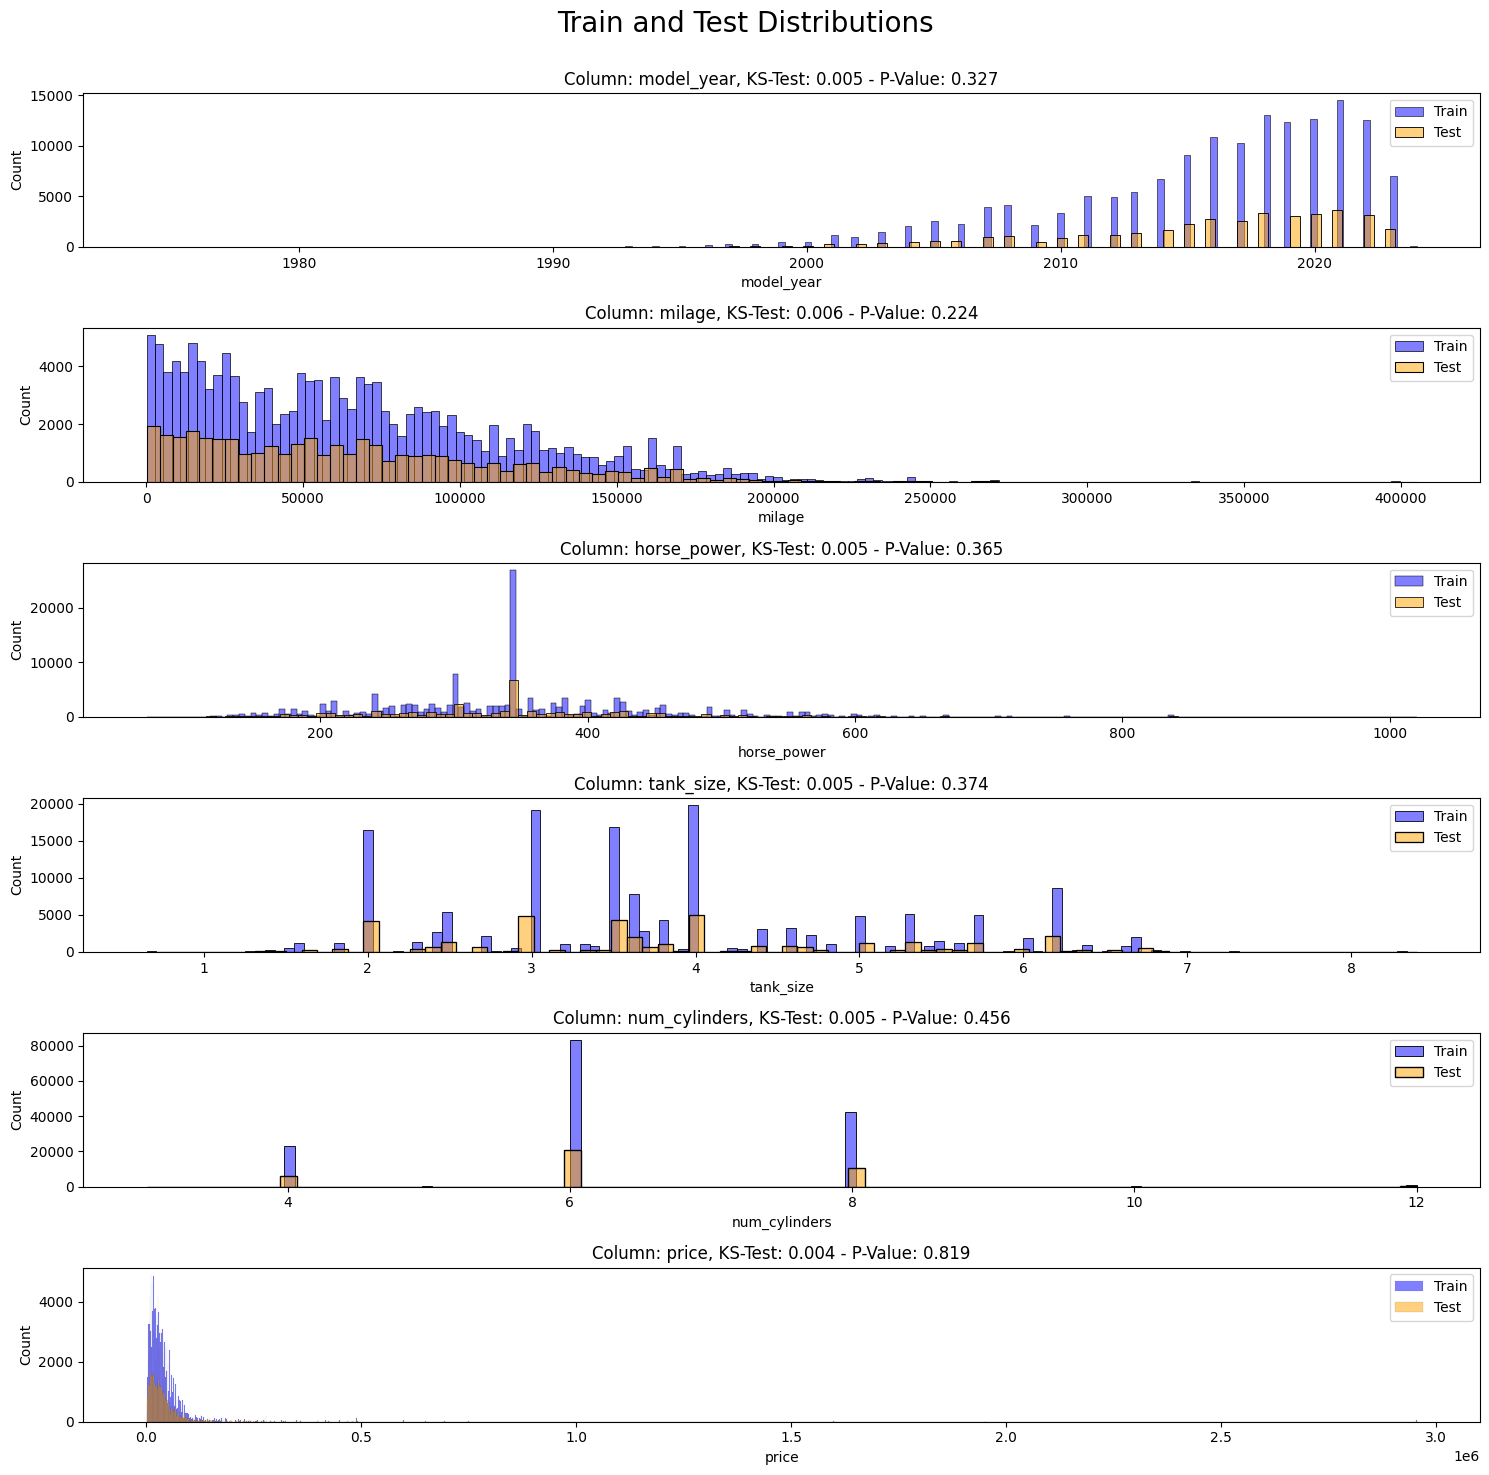

In [244]:
columns_to_hist = ['model_year', 'milage', 'horse_power', 'tank_size', 'num_cylinders', 'price']

fig, axes = plt.subplots(6, 1, figsize=(15, 15))
for i, column in enumerate(columns_to_hist):
    sns.histplot(df_train[column], ax=axes[i], color='blue', label='Train', alpha=0.5)
    sns.histplot(df_test[column], ax=axes[i], color='orange', label='Test', alpha=0.5)
    res,pval = ks_2samp(df_train[column],df_test[column])
    axes[i].set_title(f'Column: {column}, KS-Test: {round(res, 3)} - P-Value: {round(pval, 3)}')
    axes[i].legend()
fig.suptitle('Train and Test Distributions\n', fontsize=20)
plt.tight_layout()
plt.show()

## Data Imputation Challenges

In Part 1, we filled missing values for some attributes, but this approach might have introduced inaccuracies:
- **Horsepower**: Approximately 20% of data had null values, which were filled using the mean. This approach fails to account for variations across car types (e.g., luxury vs. economy cars), resulting in unrealistic similarities.

### Plan:
We will explore better imputation techniques, such as applying regression or k-nearest neighbors (KNN) imputation to predict missing values based on related features.


## Model Explainability

The current transformation of features impairs model interpretability:

- **Brand**:
    - Previously, we grouped less common brands (beyond the top 24) into an `Other` category, which limits the model's ability to distinguish between luxury and non-luxury brands.
    - One-hot encoding added 25 features, making the model harder to interpret.

- **Color**:
    - Similar shades of colors were not grouped, leading to a large, ambiguous `Other` category.

### Plan:
1. **Brand**: Replace one-hot encoding with ordinal encoding that preserves semantic meaning (e.g., luxury vs. non-luxury brands).
2. **Color**: Group similar shades into broader categories (e.g., all shades of blue into "Blue"), reducing the size of the `Other` category.

## Features Reduction

The categorical feature **transmission** could be simplified. It is currently represented by three categories: `Automatic`, `Manual`, and `Dual`.

### Plan:
We plan to reduce this by treating `Automatic` as the base category and only explicitly representing deviations (e.g., `Manual` and `Dual`).


**Summary of Action Plan**:
1. Normalize data to handle imbalances and outliers.
2. Apply smarter imputation techniques to better fill missing values.
3. Transform features (e.g., brand, color) to improve model explainability.
4. Reduce the number of categorical features to simplify the model.

## 1.1 Explainability Changes

To enhance model explainability, we aim to transform attributes differently than in the previous exercise. 

By simplifying feature transformations, we can:
- Analyze model errors more effectively.
- Reduce the clutter caused by an excessive number of features, which hinders our ability to assess the importance of each feature.

### Motivation:
During our initial error analysis, we observed challenges in interpreting the results from SHAP graphs. The large number of features made it difficult to identify the most impactful attributes, highlighting the need for a more streamlined approach to feature transformation.

In [245]:
org_df_train = pd.read_csv('../Part_1/data/raw_train_data.csv',index_col='id')
org_df_test = pd.read_csv('../Part_1/data/raw_test_data.csv',index_col='id')

### 1.1.1 Color

In the previous exercise, we discarded colors that were not among the top 12 most common colors. However, this approach resulted in a significant loss of data.

This time, instead of discarding less common colors, we group various shades into their "origin" color. By doing so, we retain the data while simplifying the variety in the color column. This adjustment is based on the premise that differences in shades are not meaningful for predicting car prices.

This change reduces noise in the data and makes the "Other" category more cohesive, improving the model’s interpretability and prediction accuracy.

In [246]:
colors_drop = [col for col in df_train if col.startswith(("int", "ext"))]

In [247]:
df_train = df_train.drop(columns=colors_drop)
df_test = df_test.drop(columns=colors_drop)


In [248]:
df_train = pd.concat([df_train,org_df_train[['int_col', 'ext_col']]],axis=1)
df_test = pd.concat([df_test,org_df_test[['int_col', 'ext_col']]],axis=1)

Colors grouped under "Other": 

'oyster w/contrast', 'ceramic', 'gideon',
'sport', '–', 'designo magno matte',
'dark sapphire', 'custom color', 'tempest', 'lunar rock',
'nightfall mica', 'granite', 'Pink', 'c / c', 'yulong',
'go mango!', 'grigio nimbus', 'metallic'

In [249]:
def categorize_color(color):
    color = color.lower()
    # Black group
    if any(x in color for x in [
        'black', 'obsidian', 'raven', 'onyx', 'ebony', 'nero', 'blk',
        'graphite', 'charcoal', 'dark ash', 'anthracite', 'caviar', 
        'dark matter', 'magnetic', 'beluga', 'dark galvanized']):
        return 'Black'
    # White group
    elif any(x in color for x in [
        'white', 'pearl', 'ivory', 'frost', 'platinum', 'ice', 'cloud',
        'chalk', 'bianco', 'glacier', 'linen', 'very light cashmere', 
        'parchment', 'parchment.']):
        return 'White'
    # Blue group
    elif any(x in color for x in [
        'blue', 'navy', 'aqua', 'teal', 'stormy', 'blu', 'eleos']):
        return 'Blue'
    # Red group
    elif any(x in color for x in [
        'red', 'ruby', 'garnet', 'hotspur', 'pimento', 'rosso', 
        'scarlet', 'mars', 'corsa', 'chateau']):
        return 'Red'
    # Silver/Gray group
    elif any(x in color for x in [
        'silver', 'gray', 'grey', 'steel', 'medium pewter', 'slate', 
        'boulder', 'porpoise', 'light slate', 'tungsten', 'gun metallic', 
        'medium stone', 'portland', 'mesa', 'ash']):
        return 'Silver_Gray'
    # Green group
    elif any(x in color for x in [
        'green', 'verde', 'moss', 'deep cypress']):
        return 'Green'
    # Yellow/Orange group
    elif any(x in color for x in [
        'yellow', 'gold', 'orange', 'amber', 'arancio', 'hellayella', 
        'sunset drift', 'sandstone', 'tension']):
        return 'Yellow_Orange'
    # Brown group
    elif any(x in color for x in [
        'brown', 'beige', 'tan', 'mocha', 'brandy', 'chestnut', 
        'espresso', 'roast', 'dark auburn', 'aragon', 'bronze', 
        'dune', 'maroon', 'walnut', 'camel', 'caramel', 'macchiato', 
        'medium light camel', 'shale', 'cappuccino', 'tupelo']):
        return 'Brown'
    # Purple group
    elif any(x in color for x in ['purple', 'plum', 'ametrin', 'orchid', 'pink']):
        return 'Purple_Pink'
    # Default for unclassified entries
    else:
        return 'Other'

In [250]:
df_train['int_col'] = df_train['int_col'].apply(categorize_color)
df_train['ext_col'] = df_train['ext_col'].apply(categorize_color)

df_test['int_col'] = df_test['int_col'].apply(categorize_color)
df_test['ext_col'] = df_test['ext_col'].apply(categorize_color)

Converting the new int_color, ext_color to One-Hot features for the Linear Regression model.

We combine train and test data to ensure consistent encoding.

In [251]:
df_combined = pd.concat([df_train, df_test])

# Convert categorical columns to numeric using one-hot encoding
df_combined = pd.get_dummies(df_combined, columns=['int_col', 'ext_col'], drop_first=True)

# Split the combined data back into train and test sets
df_train = df_combined.iloc[:len(df_train)]
df_test = df_combined.iloc[len(df_train):]

In [252]:
df_train.head()

,model_year,milage,accident,clean_title,horse_power,tank_size,num_cylinders,automatic,manual,dual,...,int_col_Yellow_Orange,ext_col_Blue,ext_col_Brown,ext_col_Green,ext_col_Other,ext_col_Purple_Pink,ext_col_Red,ext_col_Silver_Gray,ext_col_White,ext_col_Yellow_Orange
id,,,,,,,,,,,,,,,,,,,,,
0,2007,213000,False,True,172.0,1.6,4.0,True,False,False,...,False,False,False,False,False,False,False,False,False,True
1,2002,143250,True,True,252.0,3.9,8.0,True,False,False,...,False,False,False,False,False,False,False,True,False,False
2,2002,136731,False,True,320.0,5.3,8.0,True,False,False,...,False,True,False,False,False,False,False,False,False,False
3,2017,19500,False,True,420.0,5.0,8.0,False,False,True,...,False,False,False,False,False,False,False,False,False,False
4,2021,7388,False,True,208.0,2.0,4.0,True,False,False,...,False,False,False,False,False,False,False,False,False,False


#### Testing the Changes
The transformation resulted in a reduction of the R² score by 0.001. This is an insignificant change in performance and is outweighed by the improvement in explainability that we gain from the transformation.

By grouping similar shades into their origin color and reducing the complexity of the color feature, the model becomes easier to interpret without a meaningful trade-off in accuracy.

In [253]:
print(f'R2 Score before convering the color columns: {round(0.10637623834770804, 4)}')

score_after_change = train_score_model(df_train, df_test)
print(f'R2 Score after convering the color columns: {round(score_after_change, 4)}')

R2 Score before convering the color columns: 0.1064
R2 Score after convering the color columns: 0.105



### 1.1.2 Horsepower 

To evaluate our original imputation method, we first tested filling the missing horsepower values with random values. This test allowed us to assess whether our original imputation approach was meaningful (If the R² score remains the same, then the imputation wasn't meaningful).

In [254]:
df_train_transformed = pd.read_csv('../Part_1/data/transformed_train_data.csv',index_col='id')
df_test_transformed = pd.read_csv('../Part_1/data/transformed_test_data.csv',index_col='id')

In [255]:
# Capture the original column order of df_train and df_test
original_train_columns = df_train.columns
original_test_columns = df_test.columns

min_hp = df_train['horse_power'].min()
max_hp = df_train['horse_power'].max()

# Check the value of 'horse_power' in the original dataframe and update the one-hot encoded columns in df
def replace_invalid_horse_power(row, org_row):
    if pd.isna(org_row['horse_power']):
        new_horse_power = np.random.randint(min_hp, max_hp)
        row['horse_power'] = new_horse_power
    return row

# Apply the function to the 'horse_power' column in both train and test dataframes
df_train = df_train.apply(lambda row: replace_invalid_horse_power(row, df_train_transformed.loc[row.name]), axis=1)
df_test = df_test.apply(lambda row: replace_invalid_horse_power(row, df_test_transformed.loc[row.name]), axis=1)

# Restore the original column order
df_train = df_train[original_train_columns]
df_test = df_test[original_test_columns]

#### Testing the Changes
The R² score remained essentially unchanged. This indicates that our original imputation method was not impactful enough and that we need a better approach to handle the missing values.

In [256]:
print(f'R2 Score before replacing fuel type values with random values: {round(score_after_change, 4)}')

score_after_change_ = train_score_model(df_train, df_test)
print(f'R2 Score after replacing fuel type values with random value: {round(score_after_change_, 4)}')

R2 Score before replacing fuel type values with random values: 0.105
R2 Score after replacing fuel type values with random value: 0.1045


#### Using KNN for Imputation
To improve the imputation process, we decided to use the K-Nearest Neighbors (KNN) algorithm. KNN imputes missing values based on the "similarities" between data points, making it a more informed approach.  
After experimenting with various values for the number of neighbors, we found that using 3 neighbors produced the best results.

In [257]:
from sklearn.impute import KNNImputer

df_train_transformed_copy = df_train_transformed.copy()
df_test_transformed_copy = df_test_transformed.copy()

# Apply KNNImputer
imputer = KNNImputer(n_neighbors=3)

# Impute missing values in 'horse_power' for df_train_transformed_copy and df_test_transformed_copy
df_train_transformed_copy['horse_power'] = imputer.fit_transform(df_train_transformed_copy[['horse_power']])
df_test_transformed_copy['horse_power'] = imputer.transform(df_test_transformed_copy[['horse_power']])
 
# Update the one-hot encoded columns in df_train using the imputed 'horse_power' values from org_df_train_copy
def update_horse_power_encoding(row, imputed_horse_power):
    row['horse_power'] = imputed_horse_power
    return row

# Apply the updates to df_train and df_test
df_train = df_train.apply(lambda row: update_horse_power_encoding(row, df_train_transformed_copy.loc[row.name, 'horse_power']), axis=1)
df_test = df_test.apply(lambda row: update_horse_power_encoding(row, df_test_transformed_copy.loc[row.name, 'horse_power']), axis=1)


#### Testing the Changes
Although the R² score did not change, we achieved better fairness and explainability.  
The imputation of missing horsepower values is now based on meaningful patterns in the data, rather than being arbitrary. This differentiation ensures that cars with similar attributes are assigned more accurate horsepower values.

In [258]:
print(f'R2 Score before replacing fuel type values with KNN-based values: {round(score_after_change, 4)}')

score_after_change = train_score_model(df_train, df_test)
print(f'R2 Score after replacing fuel type values with KNN-based value: {round(score_after_change, 4)}')

R2 Score before replacing fuel type values with KNN-based values: 0.105
R2 Score after replacing fuel type values with KNN-based value: 0.105


### 1.1.3 Brand

In the first exercise, we transformed the brand names into One-Hot vectors. Given the large number of brands, we limited the encoding to the 24 most common brand names, grouping the rest into an `Other` category.

However, this approach significantly inflated the number of features, making it harder to interpret the model's errors and reducing its explainability. To address this, we aimed to encode the brand names in a way that maintains the semantic value while avoiding dimensionality inflation.

#### Why Not Ordinal Encoding?
Ordinal encoding was not suitable in this case because there is no inherent order or ranking among the brands. Treating the brands as ordinal could introduce unintended bias into the model.

#### Using Target Encoding
To solve this, we opted for **Target Encoding**, which encodes a categorical feature based on the relationship between each category and the target variable (e.g., the average price for each brand in our case). Target Encoding retains the semantic meaning of the brand while reducing the number of features, as it maps each brand to a single numerical value. This encoding method is particularly effective for high-cardinality categorical features, as it avoids the dimensionality explosion caused by One-Hot encoding.

In [259]:
org_df_train.brand

id
0                  MINI
1               Lincoln
2             Chevrolet
3               Genesis
4         Mercedes-Benz
              ...      
150821             Audi
150822            Honda
150823         Cadillac
150824          Ferrari
150825             Ford
Name: brand, Length: 150826, dtype: object

In [260]:
# Restoring the original brand column and removing the ones created by one-hot encoding

cols_to_drop = [col for col in df_train.columns if col.startswith('brand')]
df_train = df_train.drop(columns=cols_to_drop)
cols_to_drop = [col for col in df_test.columns if col.startswith('brand')]
df_test = df_test.drop(columns=cols_to_drop)
df_train['brand'] = org_df_train['brand']
df_test['brand'] = org_df_test['brand']

In [261]:
# Apply target encoding to the 'brands' feature
target_encoder = ce.TargetEncoder(cols=['brand'])

df_train['brand'] = target_encoder.fit_transform(df_train['brand'], df_train['price'])
df_test['brand'] = target_encoder.transform(df_test['brand'])

#### Testing the Changes
After implementing Target Encoding, we observed an improvement in the model's R² score. This suggests that the new encoding better captures the relationship between the brand and the target variable (price). Additionally, by reducing the number of features, we achieved a more compact and interpretable model. This change effectively balances performance improvements with enhanced explainability.

In [262]:
print(f'R2 Score before target encoding the brands: {round(score_after_change, 4)}')

score_after_change = train_score_model(df_train, df_test)
print(f'R2 Score after target encoding the brands: {round(score_after_change, 4)}')

R2 Score before target encoding the brands: 0.105
R2 Score after target encoding the brands: 0.1115


In [263]:
# How the brand column looks like after target encoding

df_train['brand'][0:8]

id
0    17474.865362
1    30254.776847
2    42160.109066
3    54883.714834
4    51422.492446
5    41027.750919
6    41027.750919
7    42160.109066
Name: brand, dtype: float64

# Part 2: Improving Model Performance

## 2.1 Filling Transmission Missing Values

We identified a flaw in our previous handling of the transmission attribute—there were entries where all transmission type columns were marked as `False`. This was problematic, as our domain knowledge confirms that every car must have a transmission type: `manual`, `automatic`, or `dual`. 

In [264]:
no_transmission = df_train[(df_train['automatic'] == 0) & (df_train['manual'] == 0) & (df_train['dual'] == 0)]
no_transmission.shape[0]

443

In [265]:
for idx in no_transmission.index[:3]:
    print(f'Index: {idx}, Transmission: {org_df_train["transmission"][idx]}')
for idx in no_transmission.index[7:15]:
    print(f'Index: {idx}, Transmission: {org_df_train["transmission"][idx]}')

Index: 458, Transmission: Transmission Overdrive Switch
Index: 931, Transmission: F
Index: 1539, Transmission: –
Index: 2679, Transmission: F
Index: 3037, Transmission: Transmission Overdrive Switch
Index: 3038, Transmission: 2
Index: 3293, Transmission: 7-Speed
Index: 3585, Transmission: Variable
Index: 3630, Transmission: Transmission Overdrive Switch
Index: 4520, Transmission: Single-Speed Fixed Gear
Index: 5642, Transmission: 2


To address this, we decided to impute the missing or mislabeled transmission types with a valid value.  
Since `automatic` transmission is by far the most common type in the dataset, we set the rows with missing transmission information to `automatic`.

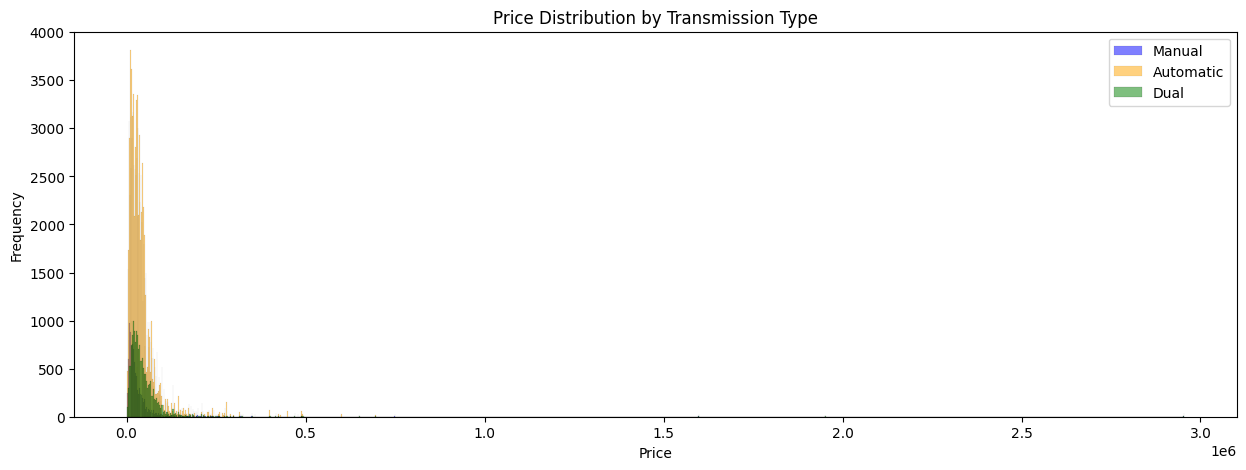

In [266]:
plt.figure(figsize=(15, 5))
sns.histplot(df_train[df_train['manual'] == 1]['price'], color='blue', label='Manual', alpha=0.5)
sns.histplot(df_train[df_train['automatic'] == 1]['price'], color='orange', label='Automatic', alpha=0.5)
sns.histplot(df_train[df_train['dual'] == 1]['price'], color='green', label='Dual', alpha=0.5)
plt.legend()
plt.title('Price Distribution by Transmission Type')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

In [267]:
df_train.loc[(df_train['automatic'] == 0) & (df_train['manual'] == 0) & (df_train['dual'] == 0), 'automatic'] = True
df_test.loc[(df_test['automatic'] == 0) & (df_test['manual'] == 0) & (df_test['dual'] == 0), 'automatic'] = True

After making this adjustment, we verified that there are no longer any entries where all transmission type columns are marked as `False`.

In [268]:
no_transmission_after_fill = df_train[(df_train['automatic'] == 0) & (df_train['manual'] == 0) & (df_train['dual'] == 0)]
no_transmission_after_fill.shape[0]

0

## 2.2 One-Hot Encoding with n-1 Columns Transformation

When encoding categorical attributes using One-Hot encoding, it is mathematically advantageous to represent an attribute with `n` unique values using `n-1` columns. This approach eliminates redundancy by assuming that a sample belongs to the "base category" when it is marked `False` for all other one-hot attributes.

In our case, the most frequent transmission type, `automatic`, was chosen as the base category.  
This transformation reduces the number of features, contributing to a more compact and efficient model.

In [269]:
df_train = df_train.drop(columns=['automatic'])
df_test = df_test.drop(columns=['automatic'])

#### Testing the Changes
The changes had minimal impact on the model's performance, as the number of missing values was very low (443 out of 15,000 samples). Additionally, the transformation of One-Hot encoding to n-1 columns did not significantly alter the results, given the small proportion of affected samples.

However, these changes are still beneficial as they contribute to feature reduction, improving the overall simplicity and efficiency of the model.

In [270]:
print(f'R2 Score before filling transmission nulls and dropiing the most frequent One-Hot attribute: {round(score_after_change, 4)}')

score_after_change = train_score_model(df_train, df_test)
print(f'R2 Score after filling transmission nulls and dropiing the most frequent One-Hot attribute: {round(score_after_change, 4)}')

R2 Score before filling transmission nulls and dropiing the most frequent One-Hot attribute: 0.1115
R2 Score after filling transmission nulls and dropiing the most frequent One-Hot attribute: 0.1114


## 2.3 Removing Outliers

From the first part of our analysis, we know there are significant outliers in the data. To handle these, we studied the distributions of the data to determine the best approach for removing them.

We began by plotting a box plot of car prices in the train and test datasets. The box plot revealed the presence of extreme outliers, with prices reaching as high as 1.5–3 million USD. However, we observed that a substantial number of cars were priced in the range of 100,000–500,000 USD. Since this range includes a significant proportion of samples, we chose not to remove all outliers but to focus on the extreme ones (above 500,000 USD). Additionally, we noted that while there are extreme higher outliers, there are no lower outliers in the data.

It is also worth noting that the distributions of train and test datasets are quite similar. This suggests that after removing the extreme outliers, the model's performance on predicting very high-priced cars (1.5–3 million USD) will likely degrade. However, overall explainability and stability will improve, especially when predicting cars in the lower and mid-price ranges.

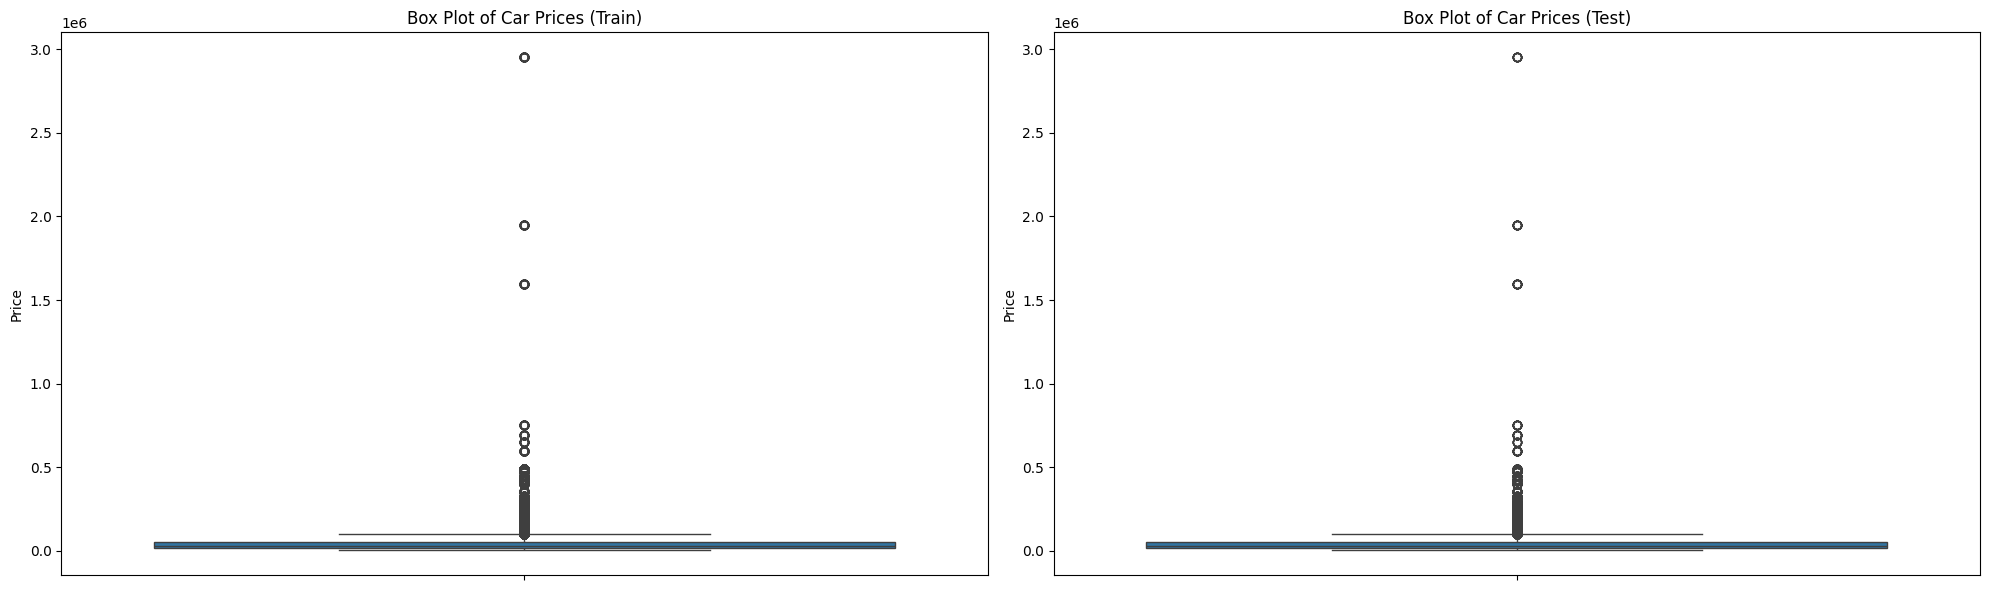

In [271]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

sns.boxplot(data=df_train, y='price', ax=axes[0])
axes[0].set_title('Box Plot of Car Prices (Train)')
axes[0].set_ylabel('Price')

sns.boxplot(data=df_test, y='price', ax=axes[1])
axes[1].set_title('Box Plot of Car Prices (Test)')
axes[1].set_ylabel('Price')

plt.tight_layout()
plt.show()

#### Approach to Removing Outliers

To remove the outliers, we:
1. Calculated the quantiles and interquartile range (IQR) of the price distribution.
2. Set a lower bound of 5,000 USD, as prices below this are unrealistic for cars.
3. Set an upper bound of **15 × IQR**, equivalent to approximately half a million USD, based on our box plot analysis.
4. Removed data points with prices outside these bounds.

We then printed the shape of the data before and after outlier removal. Approximately 3,000 data points were identified and removed as outliers - a decent portion of the dataset.

In [272]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = df_train['price'].quantile(0.25)
Q3 = df_train['price'].quantile(0.75)

# Calculate IQR (Interquartile Range)
IQR = Q3 - Q1
print(f'Q1: {Q1}, Q3: {Q3}, IQR: {IQR}')

# Check the shape of the data before removing outliers
print(f'Original df_train shape: {df_train.shape}')

# Define the lower and upper bounds for outliers with a less aggressive multiplier
lower_bound = 5000
upper_bound = 15 * IQR

# Filter out the outliers from the training data
df_train = df_train[(df_train['price'] >= lower_bound) & (df_train['price'] <= upper_bound)]

# Check the shape of the data after removing outliers
print(f'df_train shape after removing outliers: {df_train.shape}')

Q1: 17000.0, Q3: 49900.0, IQR: 32900.0
Original df_train shape: (150826, 33)
df_train shape after removing outliers: (147617, 33)


#### Testing the Impact

To evaluate the impact of removing outliers:
- We compared the R² score before and after the removal. As expected, the model struggled to predict very high-priced cars, resulting in a slight decrease in the R² score. 
- However, we believe that for test samples that are not outliers, the R² score will actually improve, because the removal of outliers should enhance the model's performance on the majority of the dataset.

In [273]:
print(f'R2 Score before removing outliers: {round(score_after_change, 4)}')

# Re-train the model and check the R2 score
score_after_change = train_score_model(df_train, df_test)
print(f'R2 Score after removing outliers: {round(score_after_change, 4)}')

R2 Score before removing outliers: 0.1114
R2 Score after removing outliers: 0.1087


#### Visualizing the Data After Outlier Removal

After removing the outliers:
- The box plot showed that the extreme outliers (above 500,000 USD) were successfully removed.
- The histogram revealed a right tail, reflecting the retained outliers in the 100,000–500,000 USD range. Despite this, the distribution appears much cleaner and more interpretable than before.

#### Conclusion

Removing extreme outliers improves the overall explainability and stability of the model, particularly for cars in the lower and mid-price ranges. While the model's performance on predicting very high-priced cars slightly worsened, this trade-off is acceptable given the proportion of data points in the retained range. Ultimately, this step enhances the model's robustness and interpretability, especially when applied to real-world scenarios.

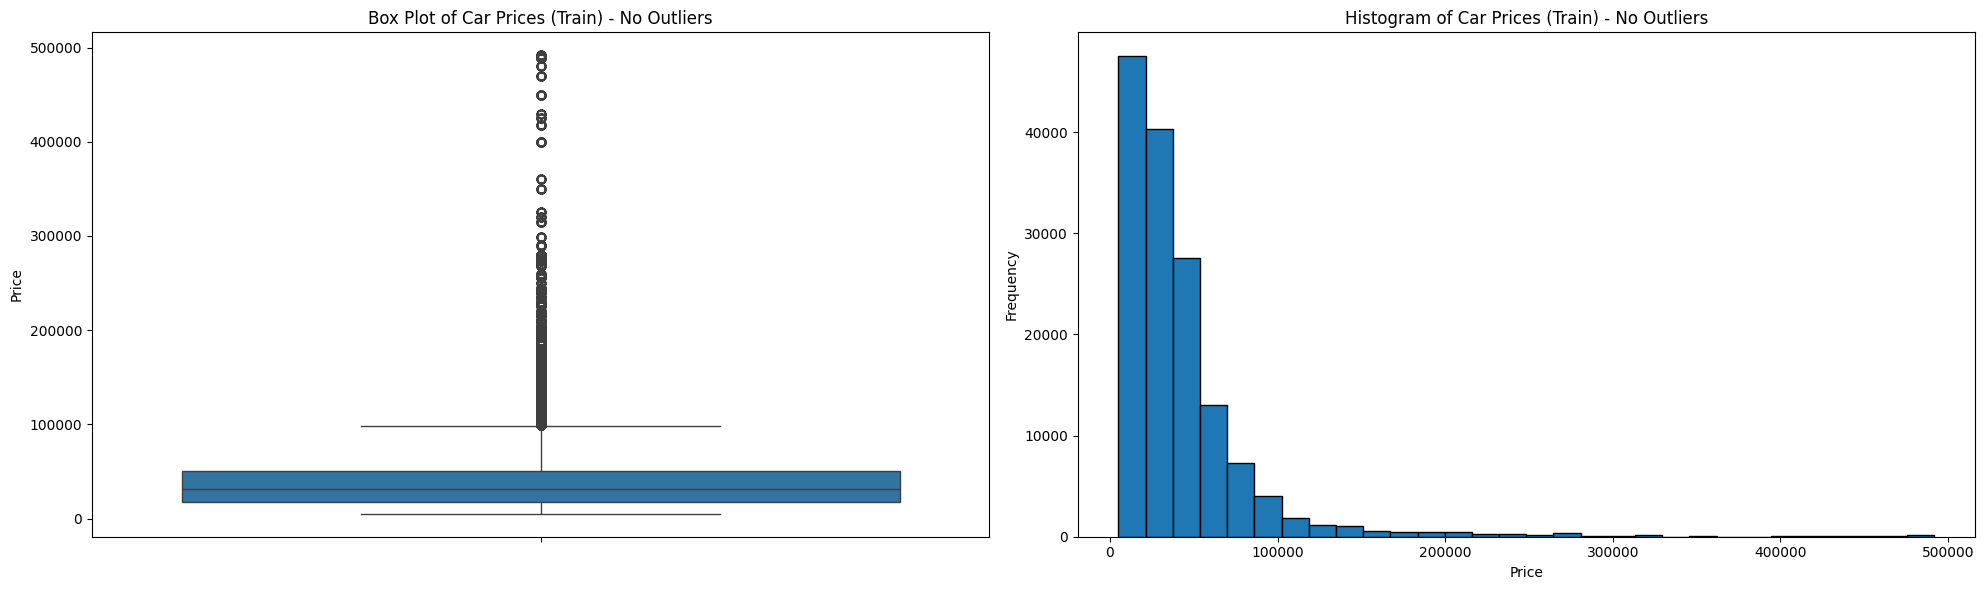

In [274]:

fig, axes = plt.subplots(1, 2, figsize=(20, 6))

sns.boxplot(data=df_train, y='price', ax=axes[0])
axes[0].set_title('Box Plot of Car Prices (Train) - No Outliers')
axes[0].set_ylabel('Price')

plt.hist(df_train['price'], bins=30, edgecolor='k')
axes[1].set_title('Histogram of Car Prices (Train) - No Outliers')
axes[1].set_xlabel('Price')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

## 2.4 Checking for Linearity and Collinearity of the Features

#### Importance of Checking Linearity and Collinearity
Understanding the relationships between features is crucial in regression modeling. Linearity refers to the direct linear relationship between features, while collinearity measures how strongly two or more features are linearly related. High collinearity (or multicollinearity) among predictors can cause issues such as:
- Inflated standard errors for coefficients, leading to less reliable estimates.
- Difficulty in interpreting the importance of individual predictors.
- Reduced model performance and stability.

To detect these issues, visualizations like heatmaps can help identify pairwise correlations, while advanced metrics such as Variance Inflation Factor (VIF) can uncover multicollinearity.

#### Heatmap Analysis
The heatmap beneath visualizes the pairwise linear correlations between features, with values ranging from -1 (perfect negative correlation) to +1 (perfect positive correlation). Key observations include:
- Most features are weakly correlated, indicated by the predominance of dark blue in the heatmap.
- A noticeable linear correlation exists between **tank size** and **number of cylinders**. However, the heatmap only highlights pairwise correlations and does not account for more complex multiple linear correlations.

<Axes: >

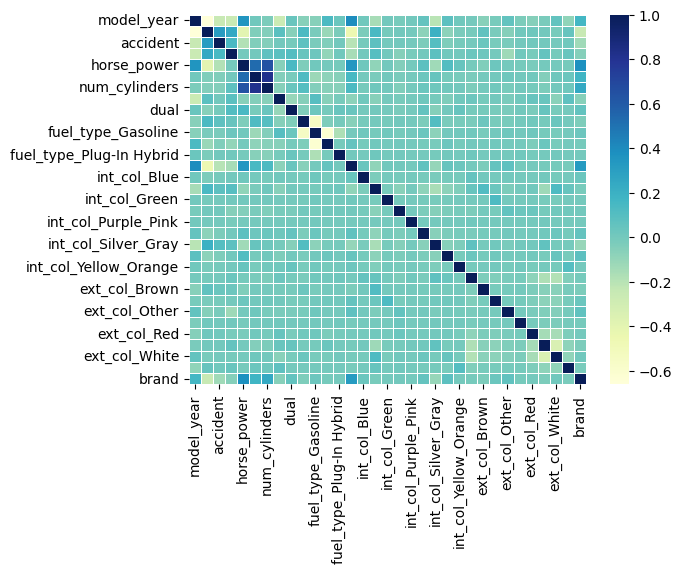

In [275]:
df_train_corr = df_train.corr()

sns.heatmap(df_train_corr, annot=False, fmt='.2f', cmap="YlGnBu", cbar=True, linewidths=0.5)

In [276]:
# Showing the correlation values that are greater than 0.8
high_corr = df_train_corr[df_train_corr>0.8]
high_corr.stack().sort_values(ascending=False)
hc = high_corr.stack().reset_index()
hc.columns=["col1","col2","corr"]
hc[hc.col1!=hc.col2]

,col1,col2,corr
6,tank_size,num_cylinders,0.81452
7,num_cylinders,tank_size,0.81452


#### Checking for Multicollinearity with Variance Inflation Factor (VIF)
To further investigate, we calculated the Variance Inflation Factor (VIF) for each feature. VIF quantifies the extent of multicollinearity in the data:
- A VIF of 1 indicates no multicollinearity.
- A VIF between 1 and 10 suggests moderate multicollinearity.
- A VIF above 10 indicates high multicollinearity, potentially problematic for the model.

In [277]:
# Calculating Variance Inflation Factors (VIF) to check for multicollinearity

from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(df, features):
    # Convert boolean columns to integers
    df_copy = df.astype({col: 'int64' for col in df.select_dtypes(include='bool').columns})
    
    vif = pd.DataFrame()
    vif["Feature"] = features
    vif["VIF"] = [variance_inflation_factor(df_copy.values, i) for i in range(len(features))]
    return vif

# Define features excluding the target variable 'price'
features = df_train.columns.drop('price')

# Calculate VIF
vif = calculate_vif(df_train, features)
vif = vif.sort_values(by='VIF', ascending=False)
vif[vif['VIF'] > 10]

,Feature,VIF
0,model_year,91.768825
6,num_cylinders,85.037516
10,fuel_type_Gasoline,47.457062
5,tank_size,31.976361
4,horse_power,29.975659


#### Findings and Interpretation
We identified 5 features with VIF scores above 10, which indicates some degree of multicollinearity. However:
- The scores are not excessively high (e.g., infinite or in the tens of thousands, as observed in class examples).
- The R² values for predicting each feature based on the others are not significant, meaning no single feature is overly predictable from the rest.

In [278]:
high_vif_features = vif[vif['VIF'] > 10]['Feature'].tolist()
high_vif_scores = vif[vif['VIF'] > 10]['VIF'].tolist()

In [279]:
for (i, target_feature) in enumerate(high_vif_features):
    # Drop the original target feature and the high-vif feature we are trying to predict
    X = df_train.drop(columns='price')
    y = df_train[target_feature]
    X = X.drop(columns=target_feature)

    # Fit a linear regression model
    linear_reg_vif = LinearRegression()
    linear_reg_vif.fit(X, y)

    # keep the non-zero coefficients
    coefficients = linear_reg_vif.coef_
    coefficients = pd.Series(coefficients, index=X.columns)
    coefficients = coefficients[coefficients.abs() > 0]
    coefficients = coefficients.sort_values(ascending=False)

    # How good is the prediction of the model for the target feature?
    y_pred_col = linear_reg_vif.predict(X)
    r2 = r2_score(y, y_pred_col)

    print(f'The feature "{target_feature}" can be predicted as a linear combination of all other features with an R2 score": {round(r2, 4)}')
    print(f'VIF: {round(high_vif_scores[i], 3)}\n')
    
    # verbose:
    # print(f'The most influential features were:')
    # print(coefficients.head(3).to_string(index=True, header=False))
    # print(coefficients.tail(3).to_string(index=True, header=False))
    # print('\n')

The feature "model_year" can be predicted as a linear combination of all other features with an R2 score": 0.5615
VIF: 91.769

The feature "num_cylinders" can be predicted as a linear combination of all other features with an R2 score": 0.7584
VIF: 85.038

The feature "fuel_type_Gasoline" can be predicted as a linear combination of all other features with an R2 score": 0.7652
VIF: 47.457

The feature "tank_size" can be predicted as a linear combination of all other features with an R2 score": 0.6998
VIF: 31.976

The feature "horse_power" can be predicted as a linear combination of all other features with an R2 score": 0.6263
VIF: 29.976



#### Conclusion
Based on these findings, we do not observe strong multicollinearity in our dataset. As such, we do not need to take corrective actions like dropping highly correlated features or transforming existing ones. The current feature set is deemed sufficient for our model.

## 2. 5 Balance of Data

### Assessing Data Balance
To evaluate the balance of our data, we divided the **price** feature into bins and analyzed the distribution of entries across these categories after removing outliers. The results revealed a **highly imbalanced dataset**, with significantly more entries in the lower-priced bins compared to the higher-priced ones. This imbalance can affect the model's performance, especially for underrepresented categories.

### Addressing Data Imbalance
The most effective way to address this issue is to **collect more training data**, particularly for the underrepresented higher-priced bins. However, generating synthetic data is not a viable solution for this dataset due to the following reasons:
1. The imbalance is substantial, requiring the generation of a large amount of synthetic data to achieve balance.
2. Generating such data may amplify anomalies already identified in Part 1 of the analysis, which could worsen the model’s explainability and integrity.
3. Verifying the quality and validity of the generated data is challenging and could lead to further inaccuracies.

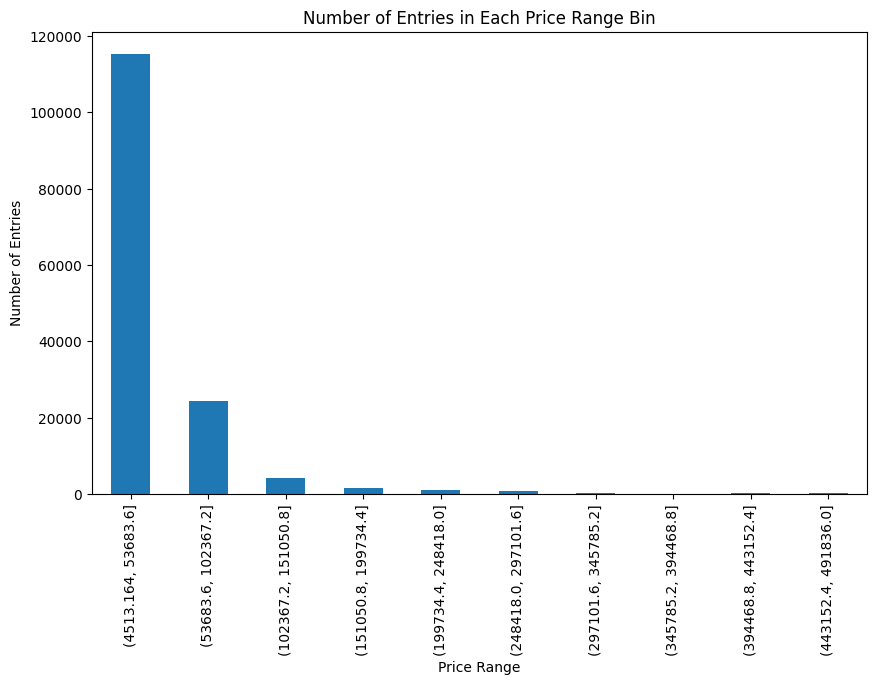

In [280]:
# Define the number of bins
num_bins = 10

df_train_bins = df_train.copy()

# Create bins for the price range
df_train_bins['price_bin'] = pd.cut(df_train_bins['price'], bins=num_bins)

# Count the number of entries in each bin
price_bin_counts = df_train_bins['price_bin'].value_counts().sort_index()

# Plot the number of entries in each bin
plt.figure(figsize=(10, 6))
price_bin_counts.plot(kind='bar')
plt.xlabel('Price Range')
plt.ylabel('Number of Entries')
plt.title('Number of Entries in Each Price Range Bin')
plt.show()

We can clearly see a great imbalance. Let's see if it influences the model's performance of the samples in the lower priced bins. If it doesn't, then our model is good on lower prices and we're okay with it.

In [281]:
# Sample 5000 random samples from the test data that are in the lowest bin and try to predict the price
# Define the lowest bin
lowest_bin = df_train_bins['price_bin'].min()

# Sample 5000 random samples from the test data that are in the lowest bin
lowest_bin_range = (lowest_bin.left, lowest_bin.right)
lowest_bin_samples = df_test[(df_test['price'] <= 100000)].sample(n=500, random_state=42)

# Predict the price for the lowest bin samples
r2_lowest_bin = train_score_model(df_train, lowest_bin_samples)

# Print the R2 score for the lowest bin samples
print(f'R2 Score for the lowest bin samples: {round(r2_lowest_bin, 4)}')

# Do the same with the highest bin

highest_bin_samples = df_test[(df_test['price'] >= 150000)].sample(n=1000, random_state=42)
# Predict the price for the lowest bin samples
r2_highest_bin = train_score_model(df_train, highest_bin_samples)

# Print the R2 score for the lowest bin samples
print(f'R2 Score for the highest bin samples: {round(r2_highest_bin, 4)}')


R2 Score for the lowest bin samples: 0.2644
R2 Score for the highest bin samples: -0.5058


### Model Performance on Imbalanced Data
To determine the impact of the imbalance on our model’s performance:
- The **original model** achieved an R² score of **0.1087** on the entire test set.
- We then evaluated the model on subsets of the test set:
  - For **low-priced samples**, the R² score was **0.2644**, which is more than double the original score.
  - For **high-priced samples**, the R² score dropped to **-0.5**, indicating poor performance. A negative R² suggests that the model performs worse than a simple mean-based prediction, which is concerning.

The drastic performance difference between these subsets highlights the impact of data imbalance. The model performs well on lower-priced entries, likely due to the abundance of training data for these prices. However, its performance on higher-priced entries is unacceptable due to the lack of sufficient representation in the training data.

### Conclusion
The imbalance in our data directly affects the model's ability to generalize across different price ranges:
- The model performs **well for lower-priced cars** but struggles significantly with higher-priced cars.
- While collecting more data for higher-priced cars would be ideal, it is not feasible given the reasons outlined earlier.

Ultimately, we conclude that the current model is suitable for applications focusing on lower-priced cars, but it is not reliable for higher-priced cars. Any practical use of the model should take this limitation into account.

**CONTINUE FROM HERE**

## 2.6 Shaping the attributes to make their relationship with the target linear

We suspect the relationship between the features and the price isn't linear so we will plot the relationships between the price and some features, and try to apply some transformations on those features.

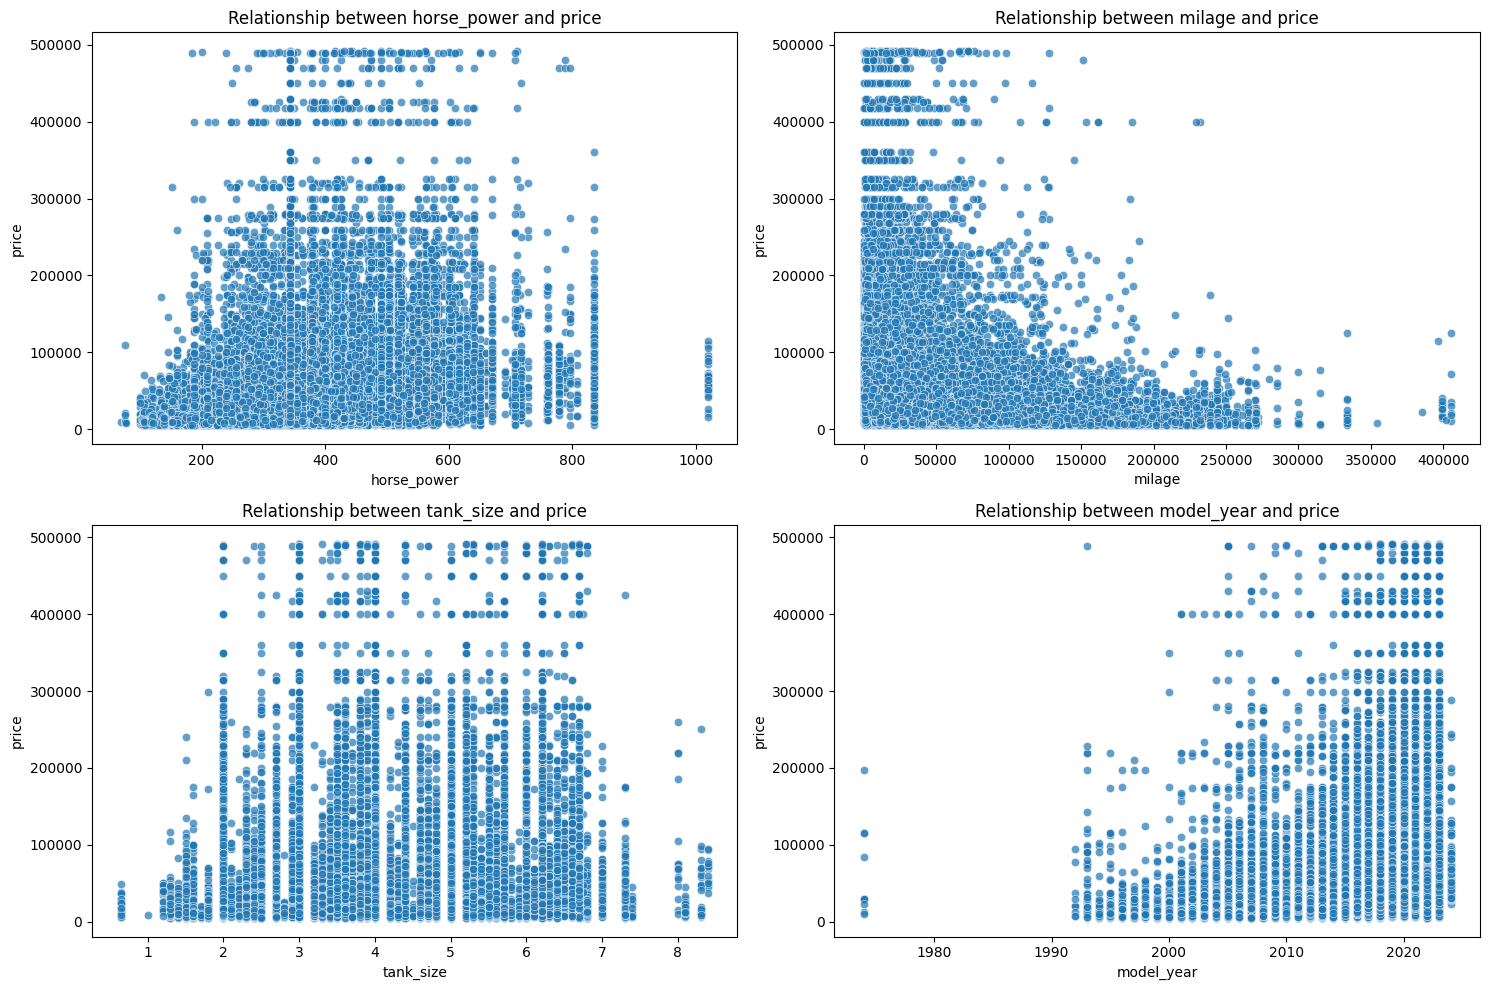

In [282]:
def plot_relationships(df, features, target):
    """
    Plots the relationship between multiple features and the target.
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.flatten()
    
    for i, feature in enumerate(features):
        sns.scatterplot(x=df[feature], y=df[target], alpha=0.7, ax=axes[i])
        axes[i].set_title(f"Relationship between {feature} and {target}")
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel(target)
    
    plt.tight_layout()
    plt.show()

plot_relationships(df_train, ['horse_power', 'milage', 'tank_size', 'model_year'], 'price')

This function calculates the correlation between this feature and the price and computes the MSE when using a simple linear regression model to try and predict the price from using only this feature.

In [283]:
def assess_feature_importance(df, feature, target):
    """
    Calculates correlation and fits a simple linear regression to assess feature importance.
    """
    # Correlation
    correlation = df[feature].corr(df[target])
    print(f"Correlation between {feature} and {target}: {correlation:.2f}")
    
    # Simple Linear Regression
    X = df[[feature]]
    y = df[target]
    model = LinearRegression().fit(X, y)
    predictions = model.predict(X)
    mse = mean_squared_error(y, predictions)
    print(f"Simple Linear Regression MSE for {feature}: {mse:.2f}")
    
    return model

model = assess_feature_importance(df_train, 'horse_power', 'price')

Correlation between horse_power and price: 0.34
Simple Linear Regression MSE for horse_power: 1763409346.66


In [284]:
model2 = assess_feature_importance(df_train, 'model_year', 'price')

Correlation between model_year and price: 0.39
Simple Linear Regression MSE for model_year: 1687416901.29


### 2.6.1 Changing model_year to age for better scale

In order to transform model_year better and have its scale smaller, instead of saving model year we'll save the age of car which will be computed by 2024 (the most recent year) and the actual model_year

In [285]:
# Change model_year to age
df_train['age'] = 2024 - df_train['model_year']
df_test['age'] = 2024 - df_test['model_year']

# Drop the model_year column
df_train = df_train.drop(columns='model_year')
df_test = df_test.drop(columns='model_year')

This function transforms the feature recieved as input according to the transformation method specified, runs the model with the new attribute and prints the new r^2 score.

the transformation include the basic ones - square, log, square root, exponent (the base is 1.1 because some of the values are big and we don't want to reach inf), and normalize (note: you can see that we normalize the test data based on the mean and variance of the train data, so we still don't know anything about the test).

## 2.7 Normalizing the Data

From the plots we saw, we could understand that we need some normalizing of the data. We checked several normalizers (e.g. StandardScaler, MinMax, BoxCox), but they didn't improve the score. Lastly we tried the 'yeo-johnson' method that works for both positive and zero values.

**The r^2 score after the normalization has increased 6 times the original value !!** 

In [286]:
scaler = PowerTransformer(method='yeo-johnson', standardize=True)

df_train_scaled = df_train.copy()
df_test_scaled = df_test.copy()

df_train_scaled = scaler.fit_transform(df_train_scaled)
df_test_scaled = scaler.transform(df_test_scaled)

# Convert back to DataFrame
df_train_scaled = pd.DataFrame(df_train_scaled, columns=df_train.columns, index=df_train.index)
df_test_scaled = pd.DataFrame(df_test_scaled, columns=df_test.columns, index=df_test.index)

print(f'R2 Score before normalizing the data: {round(score_after_change, 4)}')
score_after_change = train_score_model(df_train_scaled, df_test_scaled)  
print(f"R2 Score after normalizing the data: {score_after_change:.4f}")

R2 Score before normalizing the data: 0.1087
R2 Score after normalizing the data: 0.6101


We now re-plot the actual price vs. the predicted price, and we can actually see the improvement displayed in the graph.

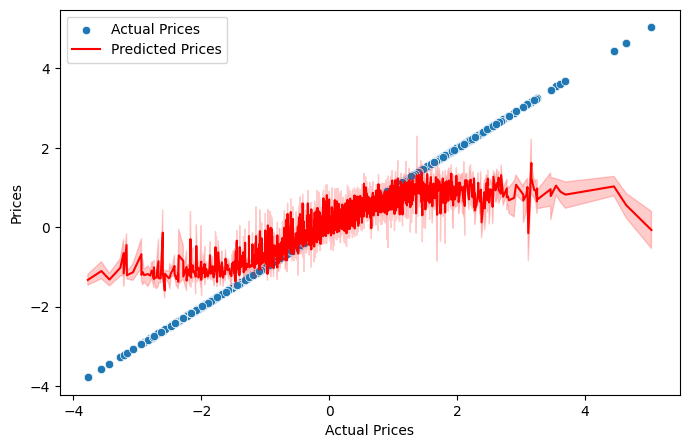

In [353]:
y_train_scaled = df_train_scaled['price']
X_train_scaled = df_train_scaled.drop(columns='price')
y_test_scaled = df_test_scaled['price']
X_test_scaled = df_test_scaled.drop(columns='price')

linear_reg = LinearRegression()
linear_reg.fit(X_train_scaled, y_train_scaled)
y_pred_scaled = linear_reg.predict(X_test_scaled)

# Create the scatter plot and line plot
fig, ax = plt.subplots(figsize=(8, 5))
sns.scatterplot(x=y_test_scaled, y=y_test_scaled, ax=ax, label='Actual Prices')
sns.lineplot(x=y_test_scaled, y=y_pred_scaled, ax=ax, color='red', label='Predicted Prices')

ax.set_xlabel('Actual Prices')
ax.set_ylabel('Prices')
ax.legend()
plt.show()

We might have lost some of the model's explainability (the boolean attributes now have values in them other than 0,1), but the improvement in the r^2 score makes up for it.

In [356]:
df_train_scaled.head()

,milage,accident,clean_title,horse_power,tank_size,num_cylinders,manual,dual,fuel_type_E85 Flex Fuel,fuel_type_Gasoline,...,ext_col_Brown,ext_col_Green,ext_col_Other,ext_col_Purple_Pink,ext_col_Red,ext_col_Silver_Gray,ext_col_White,ext_col_Yellow_Orange,brand,age
id,,,,,,,,,,,,,,,,,,,,,
2,1.321323,-0.525539,0.362657,-0.146823,1.118585,1.198914,-0.305989,-0.339798,5.821459,-3.190302,...,-0.112317,-0.127327,-0.078715,-0.04617,-0.256327,-0.560542,-0.602401,-0.141883,0.082661,1.880342
3,-0.901301,-0.525539,0.362657,0.781647,0.931724,1.198914,-0.305989,2.942923,-0.171778,0.313450,...,-0.112317,-0.127327,-0.078715,-0.04617,-0.256327,-0.560542,-0.602401,-0.141883,0.893551,0.075123
4,-1.479031,-0.525539,0.362657,-1.459938,-1.573176,-1.747665,-0.305989,-0.339798,-0.171778,0.313450,...,-0.112317,-0.127327,-0.078715,-0.04617,-0.256327,-0.560542,-0.602401,-0.141883,0.698537,-0.988316
5,-0.264427,-0.525539,0.362657,-0.897628,-1.573176,-1.747665,-0.305989,-0.339798,-0.171778,0.313450,...,-0.112317,-0.127327,-0.078715,-0.04617,-0.256327,-0.560542,1.660024,-0.141883,-0.004336,-0.136865
6,0.194956,-0.525539,0.362657,-0.015917,-0.566712,-0.173655,-0.305989,-0.339798,-0.171778,0.313450,...,-0.112317,-0.127327,-0.078715,-0.04617,-0.256327,-0.560542,-0.602401,-0.141883,-0.004336,0.265025


## 2.8 Skewness

Comparing the skewness of the original train data and the normalized one. 

As we can see, the sekwness reduced drastically (10 fold) which is great for us. 
For all those features the skewness is around 0, and milage appears to be a bit more skewed so we will examine it separately.

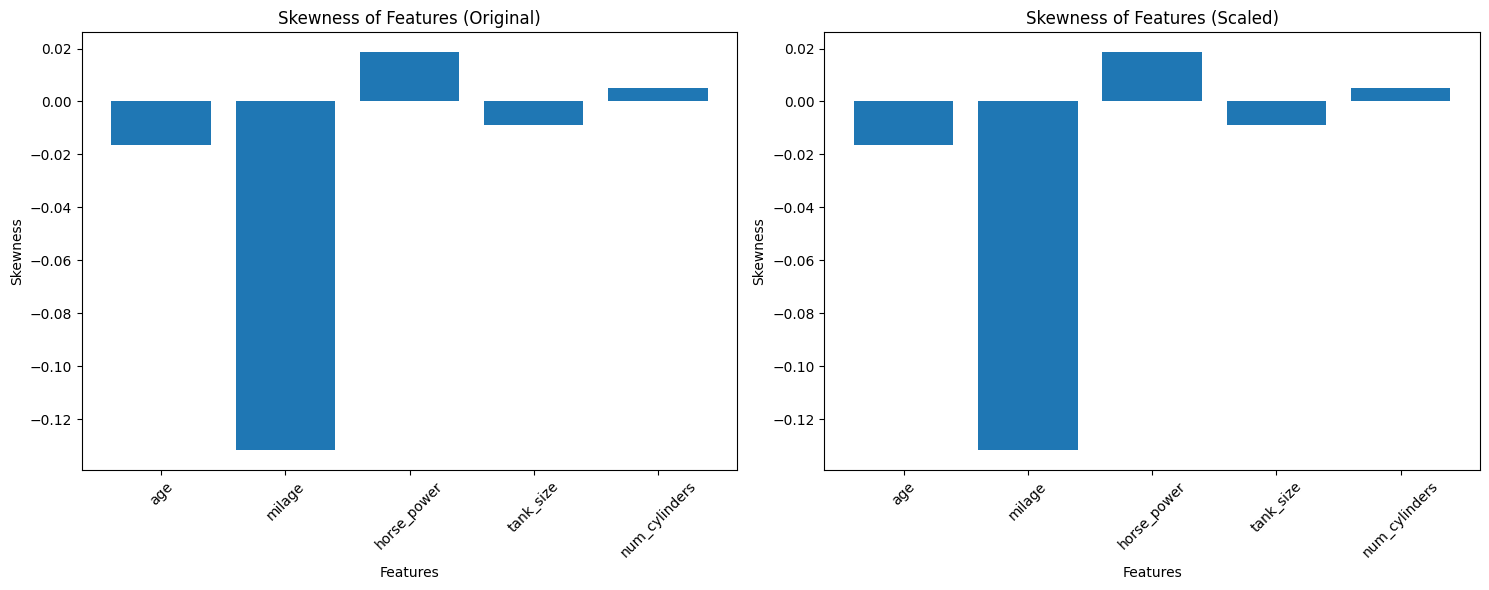

In [357]:
# List of features to check skewness
features = ['age', 'milage', 'horse_power', 'tank_size', 'num_cylinders']

# Calculate skewness for each feature
skewness = {feature: skew(df_train[feature]) for feature in features}

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot skewness of original df_train
axes[0].bar(skewness.keys(), skewness.values())
axes[0].set_xlabel('Features')
axes[0].set_ylabel('Skewness')
axes[0].set_title('Skewness of Features (Original)')
axes[0].tick_params(axis='x', rotation=45)

# Calculate skewness for scaled features
scaled_skewness = {feature: skew(df_train_scaled[feature]) for feature in features}

# Plot skewness of scaled df_train
axes[1].bar(scaled_skewness.keys(), scaled_skewness.values())
axes[1].set_xlabel('Features')
axes[1].set_ylabel('Skewness')
axes[1].set_title('Skewness of Features (Scaled)')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

From the histogram of the milage attribute we can see that it does look like it's distributed normally, and if we examine the earlier plot, we can see that the skewness of milage is -0.12 which is very small indeed.

In [358]:
df_train_scaled['milage'].hist()

<Axes: >

## 2.9 Hyperparameter Tuning

We used the Linear regression model. Since it has a closed form - there are no hyperparameters.

# Part 3: Analysing the Improved Model

In [360]:
df_train = df_train_scaled.copy()
df_test = df_test_scaled.copy()

y_train = df_train['price']
X_train = df_train.drop(columns='price')

y_test = df_test['price']
X_test = df_test.drop(columns='price')

In [365]:
# residuals
residuals = y_test - y_pred_scaled
max_error = residuals.abs().max()
max_idx = int(residuals[residuals==max_error].index[0] - df_train.shape[0])

Residuals plots

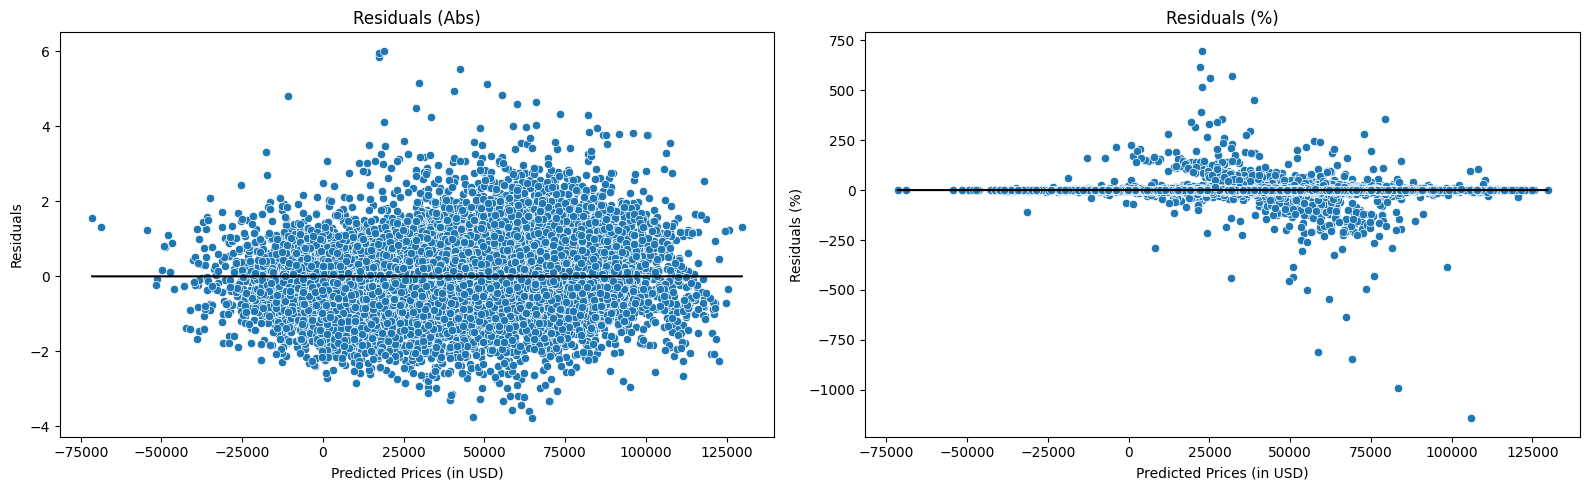

In [366]:
# This cell may take a few minutes to run

fig, ax = plt.subplots(1, 2, figsize=(16, 5))

# Plot for absolute residuals
sns.scatterplot(x=y_pred, y=residuals, ax=ax[0])
sns.lineplot(x=y_pred, y=[0]*len(y_pred), ax=ax[0], color='black')
ax[0].set_title("Residuals (Abs)")
ax[0].set_xlabel("Predicted Prices (in USD)")
ax[0].set_ylabel("Residuals")

# Plot for percentage residuals
sns.scatterplot(x=y_pred, y=residuals/y_test, ax=ax[1])
sns.lineplot(x=y_pred, y=[0]*len(y_pred), ax=ax[1], color='black')
ax[1].set_title("Residuals (%)")
ax[1].set_xlabel("Predicted Prices (in USD)")
ax[1].set_ylabel("Residuals (%)")

plt.tight_layout()

plt.show()

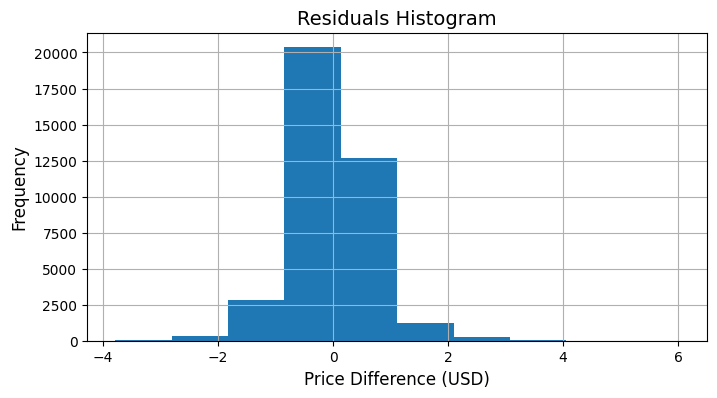

In [367]:
fig, ax = plt.subplots(figsize=(8,4))
residuals.hist(ax=ax)
ax.set_title('Residuals Histogram', fontsize=14)
ax.set_xlabel('Price Difference (USD)', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)

plt.show()

#### 4.2.5 Model Performance Overview

- **Percentage of Predictions with Less than 5% Error**: Only **6.33%** of the predictions have an error margin of less than 5%, indicating that the model is frequently making substantial errors in its predictions.

- **Percentage of Predictions with More than 20% Error**: A significant **75.36%** of predictions exhibit an error greater than 20%, highlighting that the model's predictions are often far off from the actual values.

In [368]:
relative_residuals=residuals/y_test
relative_absolute_residuals=relative_residuals.abs()

less_than_5 = len(relative_absolute_residuals[relative_absolute_residuals<0.05])/len(relative_absolute_residuals)
more_than_20 = len(relative_absolute_residuals[relative_absolute_residuals>0.2])/len(relative_absolute_residuals)

print(f"Percentage of predictions with less than 5% error: {less_than_5:.2%}")
print(f"Percentage of predictions with more than 20% error: {more_than_20:.2%}")

Percentage of predictions with less than 5% error: 4.59%
Percentage of predictions with more than 20% error: 81.62%


SHAP - add another

Max Error WaterChart

In [369]:
# Reset the index of residuals to ensure alignment
residuals_reset = residuals.reset_index(drop=True)
y_test_reset = y_test.reset_index(drop=True)
y_test_reset = pd.Series(y_pred).reset_index(drop=True)


In [370]:
# Find the index of the maximum error
max_idx = residuals_reset[residuals_reset == max_error].index[0]

print(f"Max Error: {max_error:,.3f}, at index {max_idx}")

# Print the actual and predicted values for the row with the max error
print(f"Actual: {y_test_reset.loc[max_idx]:,.3f}, Predicted: {y_pred_reset[max_idx]:,.3f}")

Max Error: 6.014, at index 30195
Actual: 19,038.186, Predicted: 19,038.186


In [371]:
# Print the car with the max error
X_test_reset = X_test.reset_index(drop=True)
print(X_test_reset.loc[max_idx][:13])
print()
print('Other One-Hot features...')
print()
print(f"price: 		   {y_test_reset.loc[max_idx]}")

milage                      0.599662
accident                   -0.525539
clean_title                 0.362657
horse_power                 0.085890
tank_size                   0.246057
num_cylinders              -0.173655
manual                     -0.305989
dual                       -0.339798
fuel_type_E85 Flex Fuel    -0.171778
fuel_type_Gasoline          0.313450
fuel_type_Hybrid           -0.194691
fuel_type_Plug-In Hybrid   -0.053353
int_col_Blue               -0.068927
Name: 30195, dtype: float64

Other One-Hot features...

price: 		   19038.185841767583


In [372]:
max_idx_df

,milage,accident,clean_title,horse_power,tank_size,num_cylinders,manual,dual,fuel_type_E85 Flex Fuel,fuel_type_Gasoline,...,ext_col_Brown,ext_col_Green,ext_col_Other,ext_col_Purple_Pink,ext_col_Red,ext_col_Silver_Gray,ext_col_White,ext_col_Yellow_Orange,brand,age
30195,0.599663,-0.525538,0.362658,0.085891,0.246058,-0.173654,-0.305988,-0.339797,-0.171777,0.313451,...,-0.112316,7.853814,-0.078714,-0.046169,-0.256326,-0.560541,-0.6024,-0.141882,0.216728,2.434617


In [373]:
max_idx_df = X_test_reset.loc[max_idx].to_frame().T
max_idx_df['price'] = y_pred_reset.loc[max_idx]
max_idx_df += 1e-6  # Add a small constant to avoid zero values
# Move the 'price' column to be the 13th column
price_col = max_idx_df.pop('price')
max_idx_df.insert(12, 'price', price_col)


# Transform the prediction back to the original scale
y_pred_original_scale = scaler.inverse_transform(max_idx_df)
y_pred_original_scale = pd.DataFrame(y_pred_original_scale, columns=df_train.columns)
# y_pred_original_scale[0][12]

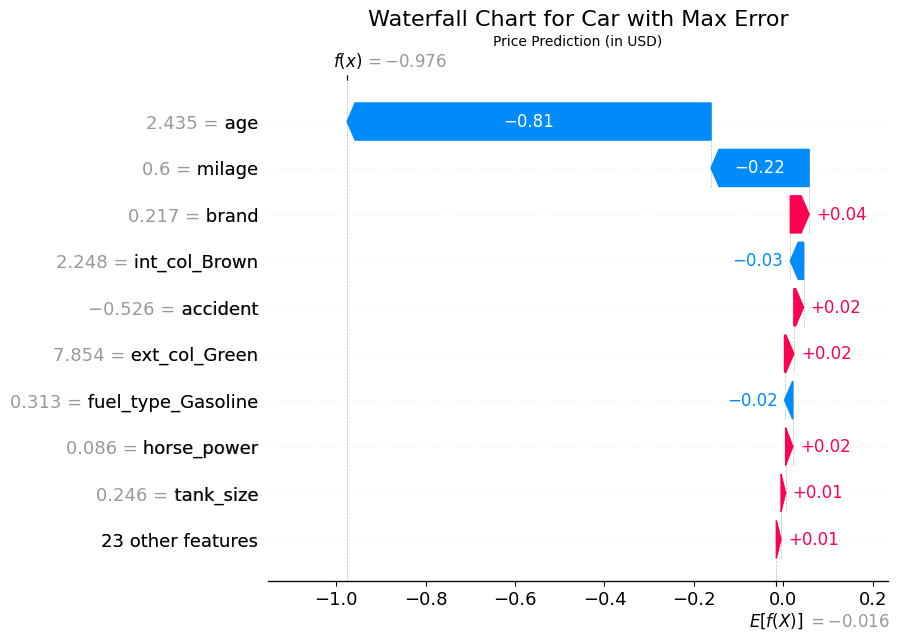

In [374]:
# Plot a waterfall chart for the row with the max error
shap.initjs()

explainer = shap.Explainer(linear_reg, X_train)
shap_values = explainer(X_test_reset)

max_idx = residuals_reset.idxmax()

shap_value_for_car = shap_values[max_idx]

shap.waterfall_plot(shap_value_for_car, show=False)  # Prevent the plot from being displayed immediately

# Add customizations
plt.title("Waterfall Chart for Car with Max Error", fontsize=16)

plt.xlabel("Price Prediction (in USD)")
plt.ylabel("Most Important Features")

plt.show()

In [375]:
columns = ['age', 'milage', 'brand', 'int_col_Brown', 'accident', 'ext_col_Green', 'fuel_type_Gasoline', 'horse_power', 'tank_size']
to_print = y_pred_original_scale[columns].copy()
to_print.loc[:, 'predicted_price'] = y_pred_original_scale['price']
to_print.loc[:, 'actual_price'] = org_df_test.loc[max_idx + difference, 'price']

to_print

,age,milage,brand,int_col_Brown,accident,ext_col_Green,fuel_type_Gasoline,horse_power,tank_size,predicted_price,actual_price
0,30.000016,85200.061945,43983.803474,1.000033,6.463275e-08,NaN,1.0,343.353647,4.000001,NaN,41741


In [376]:
predicted_price = y_pred_original_scale['price']
actual_price = org_df_test.loc[max_idx + difference]['price']
error = predicted_price - actual_price

# MSE

In [378]:
X_test_and_y_pred = X_test.copy()
X_test_and_y_pred['price'] = y_pred_scaled
price_col = X_test_and_y_pred.pop('price')
X_test_and_y_pred.insert(12, 'price', price_col)
X_test_and_y_pred += 1e-6
X_test_and_y_pred_transformed = scaler.inverse_transform(X_test_and_y_pred)
X_test_and_y_pred_transformed = pd.DataFrame(X_test_and_y_pred_transformed, columns=df_train.columns)

y_pred_scaled = X_test_and_y_pred_transformed['price']
y_test_scaled = org_df_test['price']

In [379]:
X_test_and_y_pred_transformed['price']

0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
         ..
37702   NaN
37703   NaN
37704   NaN
37705   NaN
37706   NaN
Name: price, Length: 37707, dtype: float64

In [381]:


np.isnan(y_pred_scaled)


0        True
1        True
2        True
3        True
4        True
         ... 
37702    True
37703    True
37704    True
37705    True
37706    True
Name: price, Length: 37707, dtype: bool

In [329]:
y_pred_scaled.isna().sum()

np.int64(35738)

In [331]:
print(f"Mean Absolute Percentage Error: {round(mean_absolute_percentage_error(y_test_scaled, y_pred_scaled) * 100, 2)} %")
print(f"Mean Absolute Error: {mean_absolute_error(y_test_scaled, y_pred_scaled):,.0f}")
print(f"Root Mean Squared Error: {np.sqrt(mean_squared_error(y_test_scaled, y_pred_scaled)):,.0f}")

ValueError: Input contains NaN.

last time:

Mean Absolute Percentage Error: 75.7 %  
Mean Absolute Error: 22,882  
Root Mean Squared Error: 74,817

## error analysis summary

- Old R2 is vs new R2
- Residual errors >20 etc
- MAPE, MAE, RMSE

# Part 4: Conclusions & Creative Applications

PermutationExplainer explainer: 501it [00:10,  5.23it/s]                         


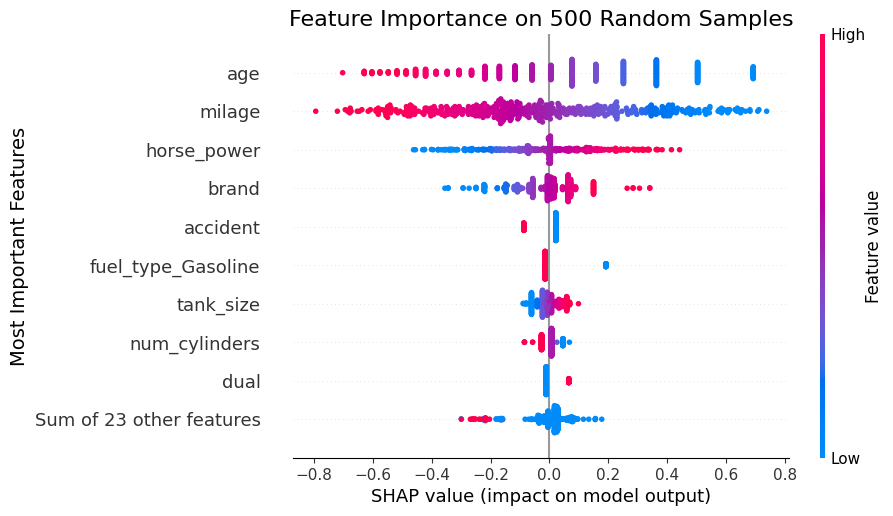

In [ ]:
# Sample the training data
shap_sample = X_train.sample(500, random_state=0)

# Convert boolean columns to integers
shap_sample = shap_sample.map(lambda x: int(x) if isinstance(x, bool) else x)

# Create the SHAP explainer
explainer = shap.Explainer(linear_reg.predict, shap_sample)

# Compute SHAP values
shap_values = explainer(shap_sample)

# Plot the SHAP values
shap.plots.beeswarm(shap_values, show=False)  # Prevent the plot from being displayed immediately

# Add customizations
plt.title("Feature Importance on 500 Random Samples", fontsize=16)
plt.ylabel("Most Important Features", fontsize=14)

# Saving the plot
# plt.savefig('./images/feature_importance_on_500_random_samples.png')

plt.show()

## correlation with the price

<Axes: >

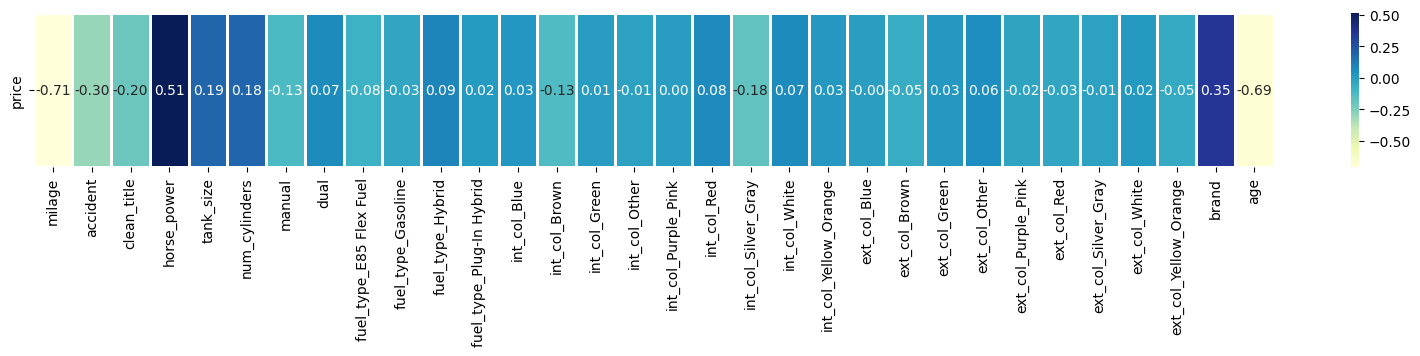

In [ ]:
%matplotlib inline

df_train_corr = df_train.corr(method="pearson").loc[["price"]]
df_train_corr = df_train_corr.drop(columns="price")
fig, ax = plt.subplots(figsize=(20,2))
sns.heatmap(df_train_corr, annot=True, fmt='.2f', cmap="YlGnBu", cbar=True, linewidths=1,ax=ax)

Surprising influential eatures? not really

### Business Applications


- Dynamic pricing strategies for car dealerships

- Insurance risk assessment

### Consumer-Oriented Tools

- Price prediction calculator for car buyers

- Evaluation tool for trade-ins and private sales

### Research & Policy Insights

- Understanding factors influencing vehicle valuations

- Environmental policy research (e.g., electric vs. combustion engine pricing)

- Consumer behavior studies

### Advanced Predictive Modeling

- Anomaly detection in car pricing